<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Pi_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

# from other notebooks
# import import_ipynb
# from dataloaders import DataLoader

In [2]:
# load MNIST dataset both train and test
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51124738.84it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 56978219.11it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 52978285.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10214760.73it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PiCon2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
        super(PiCon2D, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

        # Weight and bias initialization
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def pi_conv2d(self, input, weight, bias=None, stride=1, padding=0):
        """
        Function to process an input with a custom convolution.
        """
        batch_size, in_channels, in_h, in_w = input.shape
        out_channels, _, kh, kw = weight.shape

        # Calculate output dimensions
        out_h = (in_h + 2 * padding - kh) // stride + 1
        out_w = (in_w + 2 * padding - kw) // stride + 1

        # Unfold input tensor
        unfold = torch.nn.Unfold(kernel_size=(kh, kw), stride=stride, padding=padding)
        inp_unf = unfold(input)

        # Reshape weight for matrix multiplication
        w_ = weight.view(out_channels, -1).t()

        # Perform convolution
        if bias is None:
            out_unf = torch.exp(torch.log(torch.abs(inp_unf.transpose(1, 2))).matmul(w_).transpose(1, 2))
        else:
            out_unf = (inp_unf.transpose(1, 2).matmul(w_) + bias).transpose(1, 2)

        # Reshape output tensor
        out = out_unf.view(batch_size, out_channels, out_h, out_w)
        return out

    def forward(self, x):
        x = self.pi_conv2d(x, self.weight, self.bias, self.stride, self.padding)  # Feature extraction
        x = x.reshape(x.size(0), -1)  # Flatten the inputs

        # Dynamically calculate the input features for the fully connected layer
        in_features = x.size(1)
        fc = nn.Sequential(
            nn.Linear(in_features, 128),  # in_features is dynamically set
            nn.ReLU(),
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )

        x = fc(x)  # Fully connected layers
        return F.log_softmax(x, dim=1)  # Softmax activation for classification



In [5]:
model = PiCon2D(1,32)

In [6]:
# loss function
loss_func = nn.CrossEntropyLoss()

In [7]:
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data, target

        output = model(data)

        # Ensure output shape: [batch_size, num_classes]
        # Ensure target shape: [batch_size] with class indices

        # Calculate loss
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, pred = output.max(1)  # Get the predicted class
        train_acc += target.eq(pred).sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)  # Correctly normalize accuracy

    return train_loss, train_acc * 100  # Convert accuracy to percentage


In [9]:
def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

In [10]:
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

--- Epoch 1 ---
	Train loss: 2.3055, acc: 10.1350%
	Val loss: 2.3050, acc: 0.0980%
--- Epoch 2 ---
	Train loss: 2.3052, acc: 9.8367%
	Val loss: 2.3038, acc: 0.1060%
--- Epoch 3 ---
	Train loss: 2.3044, acc: 10.3883%
	Val loss: 2.3055, acc: 0.0990%
--- Epoch 4 ---
	Train loss: 2.3046, acc: 9.9700%
	Val loss: 2.3045, acc: 0.1042%
--- Epoch 5 ---
	Train loss: 2.3042, acc: 10.2267%
	Val loss: 2.3036, acc: 0.1002%
--- Epoch 6 ---
	Train loss: 2.3039, acc: 10.2150%
	Val loss: 2.3036, acc: 0.1015%
--- Epoch 7 ---
	Train loss: 2.3040, acc: 10.2733%
	Val loss: 2.3043, acc: 0.0985%
--- Epoch 8 ---
	Train loss: 2.3043, acc: 9.7800%
	Val loss: 2.3047, acc: 0.0929%
--- Epoch 9 ---
	Train loss: 2.3040, acc: 9.9983%
	Val loss: 2.3049, acc: 0.0958%
--- Epoch 10 ---
	Train loss: 2.3045, acc: 10.0533%
	Val loss: 2.3039, acc: 0.0993%


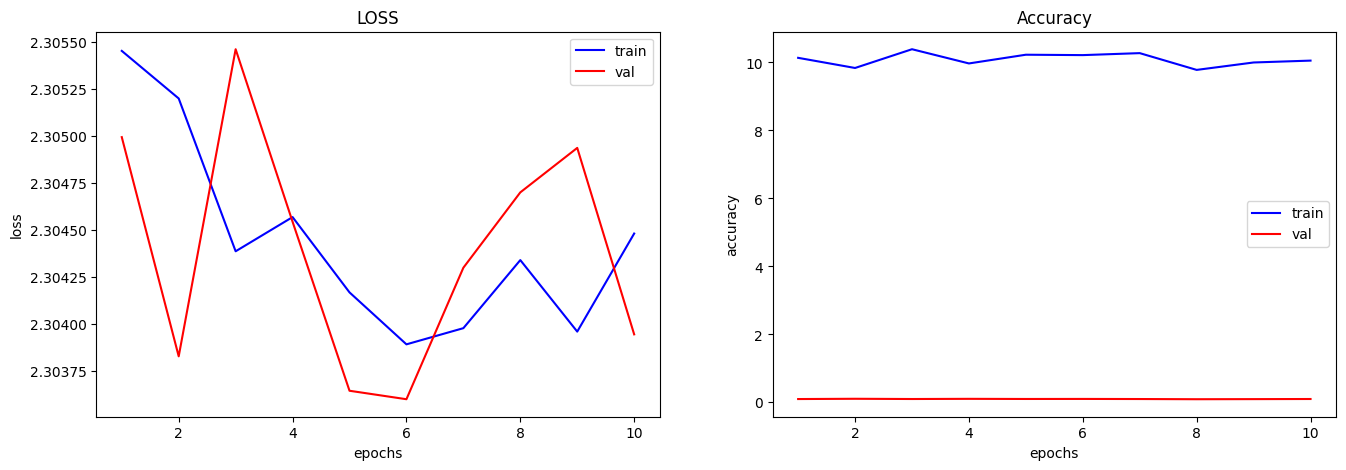

In [11]:
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()